## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby usunąć artefakty należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtr (np. 21).
2. Stwórz okno np. Hamminga (`np.Hmming') o zadanym rozmiarze.
3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:
        hanning2d = np.outer(hanning, hanning)
4. Stwórz filtr wzorcowy filtr idealny tak samo jak w poprzednim ćwczeniu.
Rozmiar wzorcowego filtra musi być taki sam jak zdefiniowany w punkcie pierwszym.
5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.
        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)
6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.
7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Oprację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.
8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

(-0.5, 511.5, 511.5, -0.5)

<Figure size 432x288 with 0 Axes>

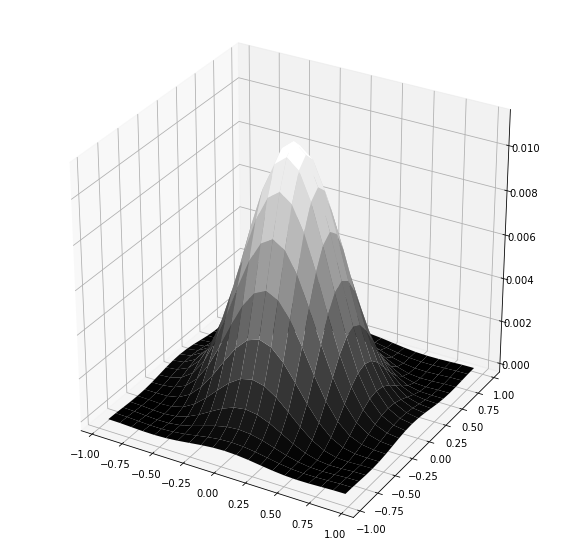

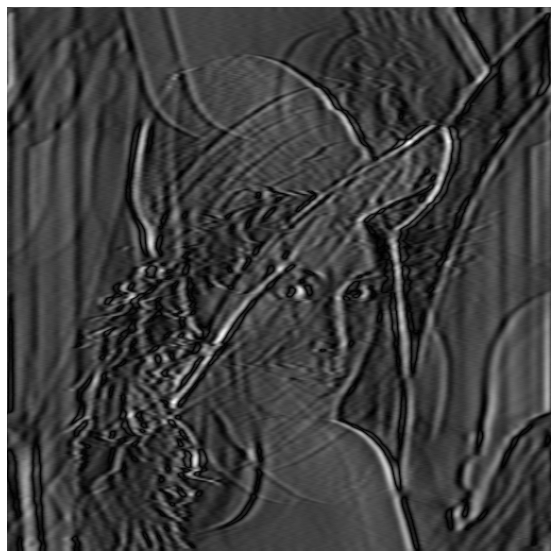

In [27]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

# Load required files
if not os.path.exists("literki.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/literki.bmp --no-check-certificate
if not os.path.exists("wzorA.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/wzorA.bmp --no-check-certificate
if not os.path.exists("lena.bmp") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/lena.bmp --no-check-certificatef
        
lena = cv2.imread('lena.bmp', cv2.IMREAD_GRAYSCALE)
plt.gray()        


image = lena
rozmiar_filtra = 21

hamming = np.hamming(rozmiar_filtra)
hamming2d= np.outer(hamming, hamming)


FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(rozmiar_filtra))
FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, rozmiar_filtra]))
FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(rozmiar_filtra))
FSpaceColsM = np.outer(np.ones([1, rozmiar_filtra]), FSpaceCols)

FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

FilterF = FreqR <= 0.1


FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
FilterFidft = cv2.idft(np.float32(FilterFRot3), flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)


filterH = FilterFI*hamming2d


iX, iY = image.shape
fX, fY = filterH.shape
diffX= iX - fX
diffY= iY - fY



filterH_resized= cv2.copyMakeBorder(filterH, 0, diffX, 0, diffY, cv2.BORDER_CONSTANT, value=0)
dft_filter = cv2.dft(np.float32(filterH_resized),flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
shifted_filter=np.fft.fftshift(dft_filter)
filterA, F = cv2.cartToPolar(shifted_filter[0], shifted_filter[1])




dft = cv2.dft(np.float32(image),flags = cv2.DFT_COMPLEX_OUTPUT)
shifted=np.fft.fftshift(dft)

shifted_f = shifted * filterA

f_ishift = np.fft.ifftshift(shifted_f)
img_back = abs(cv2.idft(f_ishift))
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])




figFilter = plt.figure(figsize=(10,10))
axsFilter = figFilter.add_subplot(projection='3d')
axsFilter.plot_surface(FSpaceRowsM, FSpaceColsM, filterH, rstride=1, cstride=1, cmap=plt.get_cmap('gray'), linewidth=0)


f, tab = plt.subplots(1,1,figsize=(10,10))
tab.imshow(img_back)
tab.axis('off')